## Dataset: отзывы о приложении (`'Ru'`)

Задание из 2-х частей.
Берем отызывы за лето
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
from stop_words import get_stop_words
from string import punctuation
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import word_tokenize
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from nltk.probability import FreqDist
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping 
from gensim.models import Word2Vec
import multiprocessing

Using TensorFlow backend.


In [2]:
seed = 42
max_words = 2000
max_len = 50
# Training
epochs = 20
batch_size = 4096
vec_len = 10

sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

data = pd.read_excel('data/отзывы за лето.xls', parse_dates=[2])

TARGET = 'target'
PROCESSED = 'preprocessed'

In [3]:
data

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


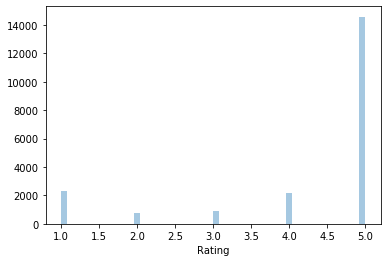

In [4]:
sns.distplot(data['Rating'], kde=False, label='Rating distribution')
# sns.distplot(data.Date, kde=False, color='green', ax=ax[1])
plt.show()

In [26]:
def preprocess_text(txt):
    
    """Строковый препроцессинг"""
    
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt

def prepare_data(df: pd.DataFrame,
                 n_classes: int,
                 processed_field: str = PROCESSED,
                 target_field: str = TARGET) -> pd.DataFrame:
    
    assert n_classes in [2,5], 'Bad Number of classes'
    
    print(f"Data preparing...", end="")
    
    """
    Предобработка данных под тип классификатора
    """
    
    
    df[processed_field] = df['Content'].apply(preprocess_text)
    
    if n_classes == 2:
        df = df[df['Rating'] != 3]
        df[target_field] = (df['Rating'] > 3).astype('uint8')
        
    else:
        df[target_field] = df['Rating'] - 1
    
    return df
    

def get_splits(data, seed=seed):
    
    print(f"Preparing splits...", end="")
    
    # Split dataset on 3 folds
    train, test = train_test_split(data, test_size=0.6, shuffle=True, random_state=seed)
    valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=seed)
    
    return train, valid, test
    
    
    
def build_train_voc(df_train, processed_field=PROCESSED):
    
    print(f"Organizing vocabulary:")
    train_corpus = " ".join(df_train[processed_field])
    # Get tokens from corpus
    tokens = word_tokenize(train_corpus)
    
    tokens_filtered = [word for word in tokens if word.isalnum()]
    dist = FreqDist(tokens_filtered)
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
    
    print('Top-10 filtered tokens:')
    print(tokens_filtered_top[:10])
    
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
    
    return vocabulary


def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]



def build_model(n_classes, max_words, max_len):
    
    print(f"Model Building...", end="")

    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(Conv1D(128, 3))
    model.add(Activation("relu"))
    model.add(GlobalMaxPool1D())
    model.add(Dense(100))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    
    print("Done. Model Summary:")
    print(model.summary())
    
    return model

def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))

    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='train accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

## Модель для мультиклассовой классификации

In [27]:
N_CLASSES = 5

# Preprocess, Split

data = prepare_data(df=data, n_classes=N_CLASSES)
df_train, df_val, df_test = get_splits(data)
vocabulary = build_train_voc(df_train, processed_field=PROCESSED)

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["preprocessed"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["preprocessed"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["preprocessed"]], dtype=np.int32)
print(f'Train.shape: {x_train.shape}, Val.shape:{x_val.shape}, Test.shape: {x_test.shape}')

y_train = keras.utils.to_categorical(df_train[TARGET], N_CLASSES)
y_val = keras.utils.to_categorical(df_val[TARGET], N_CLASSES)
y_test = keras.utils.to_categorical(df_test[TARGET], N_CLASSES)


Data preparing...Preparing splits...Organizing vocabulary:
Top-10 filtered tokens:
['приложение', 'удобно', 'работать', 'удобный', 'отлично', 'нравиться', 'отличный', 'хороший', 'супер', 'телефон']
Train.shape: (7899, 50), Val.shape:(5924, 50), Test.shape: (5925, 50)


In [28]:
model = build_model(n_classes=N_CLASSES, max_words=max_words, max_len=max_len)

Model Building...Done. Model Summary:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 128)           256000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 48, 128)           49280     
_________________________________________________________________
activation_13 (Activation)   (None, 48, 128)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               12900     
_________________________________________________________________
activation_14 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_5 (Dropo

In [29]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    verbose=0
                    )

score = model.evaluate(x_test, y_test)

C:\Users\Nickel\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


5925/5925 [==============================] - 1s 94us/step


In [30]:
print(f"Multiclass model score: {score[1]}")

Multiclass model score: 0.7939240336418152


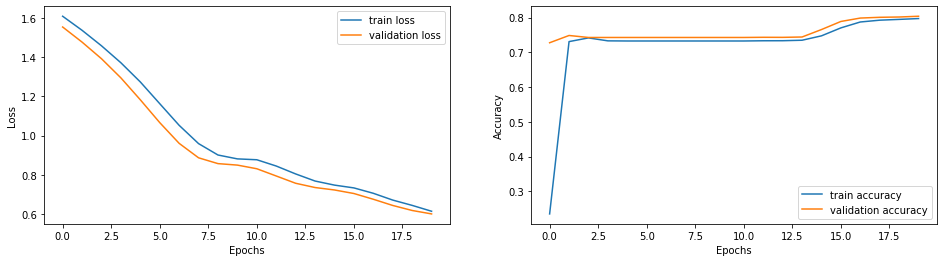

In [31]:
plot_history(history)

## Модель для бинарной классификации

In [32]:
N_CLASSES = 2

# Preprocess, Split

data = prepare_data(df=data, n_classes=N_CLASSES)
df_train, df_val, df_test = get_splits(data)
vocabulary = build_train_voc(df_train, processed_field=PROCESSED)

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["preprocessed"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["preprocessed"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["preprocessed"]], dtype=np.int32)
print(f'Train.shape: {x_train.shape}, Val.shape:{x_val.shape}, Test.shape: {x_test.shape}')

y_train = keras.utils.to_categorical(df_train[TARGET], N_CLASSES)
y_val = keras.utils.to_categorical(df_val[TARGET], N_CLASSES)
y_test = keras.utils.to_categorical(df_test[TARGET], N_CLASSES)


Data preparing...Preparing splits...Organizing vocabulary:
Top-10 filtered tokens:
['приложение', 'удобно', 'работать', 'удобный', 'отлично', 'нравиться', 'отличный', 'хороший', 'супер', 'телефон']
Train.shape: (7899, 50), Val.shape:(5924, 50), Test.shape: (5925, 50)


In [33]:
model = build_model(n_classes=N_CLASSES, max_words=max_words, max_len=max_len)

Model Building...Done. Model Summary:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 128)           256000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 48, 128)           49280     
_________________________________________________________________
activation_16 (Activation)   (None, 48, 128)           0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               12900     
_________________________________________________________________
activation_17 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropo

In [34]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    verbose=0
                    )

C:\Users\Nickel\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [35]:
res = model.predict(x_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.954


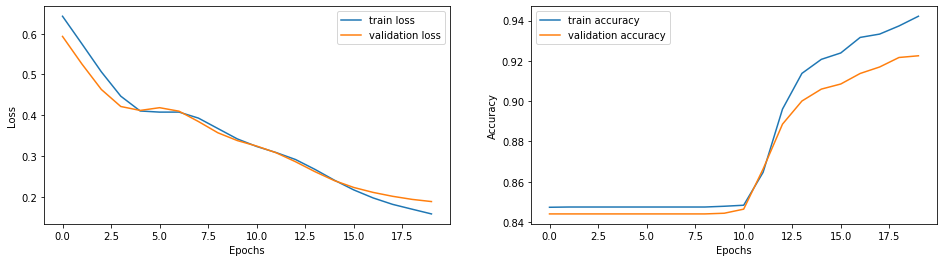

In [36]:
plot_history(history)

### Тестирование на предобученных `Word2Vec` батчах

In [39]:
data

,Rating,Content,Date,preprocessed,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложение минус хотеть большо...,1
2,5,Отлично все,2017-08-14,отлично,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,зависать 1 работа антивирус ранее пользоваться...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,удобно работать быстро,1
...,...,...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01,шляпа роот право бесполезный прога разраб охре...,0
20655,5,Ок,2017-06-01,ок,1
20656,4,Доволен,2017-06-01,довольный,1
20657,1,"Песопаснасть, рут ни нужын",2017-06-01,песопаснасть рута нужын,0


In [37]:
sentences_list_of_lists = [[sentence] for sentence in data[PROCESSED].tolist()]
sentences_list_of_lists[:10]

[['it just works'],
 ['целое удобноной приложение минус хотеть большой доступ персональный данные телефон приходиться пользоваться ограниченный режим'],
 ['отлично'],
 ['зависать 1 работа антивирус ранее пользоваться нормальный'],
 ['удобно работать быстро'],
 ['удобно норма'],
 ['удобный приложение'],
 ['устраивать'],
 ['работать чётко отличие банкомат вечно зависать тупить'],
 ['']]

In [41]:
modelW2V = Word2Vec(sentences=sentences_list_of_lists,
                    size=vec_len,
                    window=10,
                    min_count=2,
                    workers=multiprocessing.cpu_count())

In [42]:
buffer = np.random.random((max_words, vec_len))
buffer

array([[0.5852249 , 0.47988751, 0.50803219, ..., 0.15237008, 0.49394678,
        0.20456343],
       [0.9582345 , 0.01692625, 0.27341212, ..., 0.76441171, 0.59161847,
        0.07908862],
       [0.41774108, 0.51146139, 0.20223919, ..., 0.76721973, 0.17734061,
        0.14131649],
       ...,
       [0.71445957, 0.8872586 , 0.03257733, ..., 0.13945237, 0.18620286,
        0.43093534],
       [0.77041622, 0.34916656, 0.86263349, ..., 0.23045837, 0.42239291,
        0.71052651],
       [0.92823161, 0.48201719, 0.29751142, ..., 0.27921628, 0.45845356,
        0.0608051 ]])

In [43]:
for word in vocabulary:
    if word in modelW2V.wv:
#         print(word, modelW2V.wv[word])
        buffer[vocabulary[word]] = modelW2V.wv[word]

In [69]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=vec_len, weights=[buffer], input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

In [70]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=90,
                    verbose=0,
                    validation_split=0.2,
                    )

C:\Users\Nickel\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [72]:
res = model.predict(x_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.949


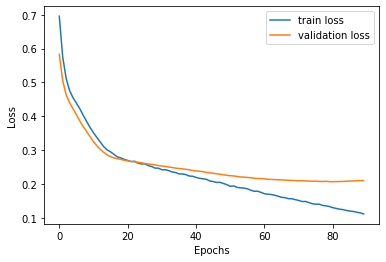

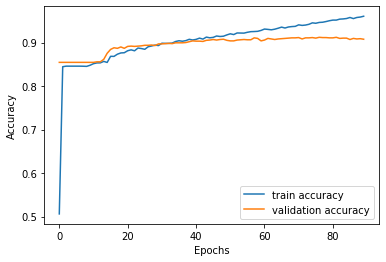

In [73]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()